In [1]:
%run SetUp.ipynb

Configuration.

In [2]:
## Configuration
Title = "Exmp_Revisit"
device = 'cpu' # "cuda:1" if torch.cuda.is_available() else "cpu"
output_path = f"./Results/{Title}"
create_directory(output_path)


# data setting 
n=4 # number of data 
d=3 # dimension of data 


# input X is shape of n x d 
X = torch.tensor([[1, 0, 1], # x1
                  [1, 2, 1], # x2
                  [1, 0, 2], # x3
                  [0, 1, 0]], # x4
                 device=device).float()
# label Y is shape of n x 1
Y = torch.tensor([[0.1], [0.2], [4], [0.1]], device=device).float()

H = X.t().matmul(X) # The Hessian Matirx
q = (X * Y).sum(0)

U, D, _ = torch.svd(H) # eigenvector decompsition of H
print("eigenvalues of H =", D)
w_star = torch.linalg.inv(H).matmul(q) # the global minimum of the linear network
w_star_cpu = w_star.cpu()
zero = np.array([0,0,0.])
print("w* =", w_star)

eigenvalues of H = tensor([10.2535,  3.5832,  0.1633])
w* = tensor([-3.8333,  0.0667,  3.9167])


Single-Layer Linear and ReLU Networks, initialization

In [3]:
w0 = 0.0001 * torch.rand(1,d) # initialization with small norm
print("w0=", w0)

# 
linear_net = Linear_Net()
linear_net.module[0].weight = nn.Parameter(copy.deepcopy(w0)) 
linear_net.to(device)
relu_net = ReLU_Net()
relu_net.module[0].weight = nn.Parameter(copy.deepcopy(w0)) 
relu_net.to(device)


# optimization Setting
lr = 0.005
criterion = nn.MSELoss()
linear_optimizer = optim.SGD(linear_net.parameters(), lr=lr)
relu_optimizer = optim.SGD(relu_net.parameters(), lr=lr)

w0= tensor([[5.3513e-05, 8.5501e-05, 9.4955e-05]])


In [4]:
linear_tr = np.empty((0,d)) # Gradient flow of the linear network
relu_tr = np.empty((0,d)) # Gradient flow of the ReLU network
linear_loss_tr = np.empty(0) # Loss of the ReLU network
relu_loss_tr = np.empty(0) # Loss of the ReLU network

Epochs = 20000
log_period = 10
for epoch in range(Epochs) :
    linear_loss = criterion(linear_net(X), Y)
    linear_loss.backward()
    linear_optimizer.step()
    linear_net.zero_grad()
    
    relu_loss = criterion(relu_net(X), Y)
    relu_loss.backward()
    relu_optimizer.step()
    relu_net.zero_grad()

    if epoch % log_period == 0 :
        linear_tr = np.append(linear_tr, linear_net.weight(), axis=0)
        relu_tr = np.append(relu_tr, relu_net.weight(), axis=0)
        linear_loss_tr = np.append(linear_loss_tr, linear_loss.item())
        relu_loss_tr = np.append(relu_loss_tr, relu_loss.item())

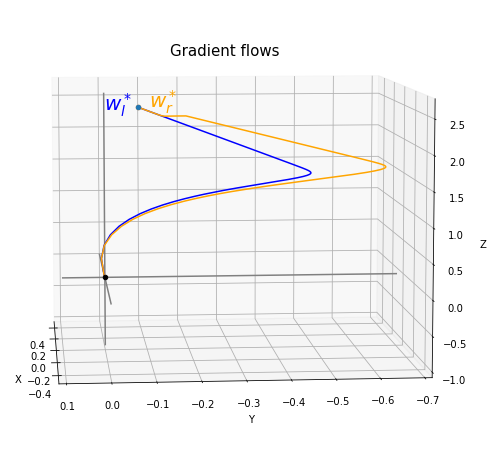

In [12]:
# draw axis
xlim_l = -0.5 ; xlim_u = 0.5
ylim_l = -0.7 ; ylim_u = 0.1
zlim_l = -1 ; zlim_u = 2.7
x_axis = np.linspace(xlim_l,xlim_u,10)
y_axis = np.linspace(ylim_l,ylim_u,10)
z_axis = np.linspace(zlim_l,zlim_u,10)

plt.ion()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.set_title("Gradient flows", fontsize=15, y=0.95)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot3D(x_axis, np.zeros_like(x_axis), np.zeros_like(x_axis), 'gray') # x-axis
ax.plot3D(np.zeros_like(y_axis), y_axis, np.zeros_like(y_axis), 'gray') # y-axis
ax.plot3D(np.zeros_like(z_axis), np.zeros_like(z_axis), z_axis, 'gray') # z-axis




# annotating local minima arrived
w_star_linear = linear_net.weight()[0]
w_star_relu = relu_net.weight()[0]
ax.scatter3D(w_star_linear[0], w_star_linear[1], w_star_linear[2])
ax.text(w_star_linear[0]+0.2, w_star_linear[1]+0.03, w_star_linear[2]-0.1, "$w_l^*$", size=20, color='blue')
ax.scatter3D(w_star_relu[0], w_star_relu[1], w_star_relu[2])
ax.text(w_star_relu[0]+0.2, w_star_relu[1]-0.02, w_star_relu[2]-0.08, "$w_r^*$", size=20, color='orange')


ax.scatter3D(zero[0], zero[1], zero[2], color='k')
ax.set_xlim(xlim_l, xlim_u)
ax.set_ylim(ylim_l, ylim_u)
ax.set_zlim(zlim_l, zlim_u)

# Convergnenc Path
ax.plot3D(linear_tr[:,0], linear_tr[:,1], linear_tr[:,2], "blue")
ax.plot3D(relu_tr[:,0], relu_tr[:,1], relu_tr[:,2], "orange")

# camera angle
ax.azim = 175 # 80 to check y-data is deactivated
ax.dist = 8
ax.elev = 7
savefig(f'{output_path}/convergence_{Epochs}.png')

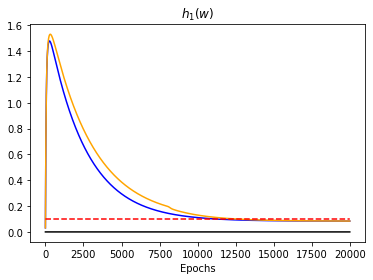

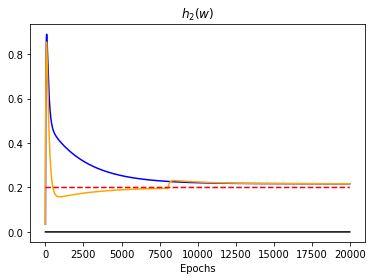

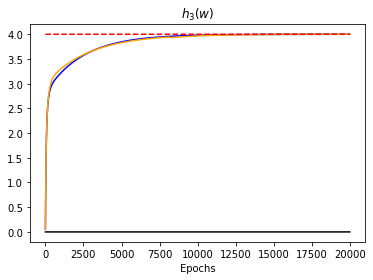

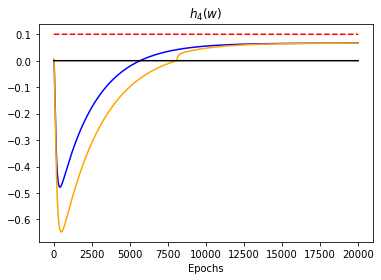

In [6]:
linear_tr_torch = torch.tensor(linear_tr).float()
relu_tr_torch = torch.tensor(relu_tr).float()

for i in range(n):
    linear_h = linear_tr_torch.matmul(X[i])
    relu_h = relu_tr_torch.matmul(X[i])
    plt.plot(log_period*np.arange(len(linear_h)), linear_h, 'blue')
    plt.plot(log_period*np.arange(len(linear_h)), relu_h, 'orange')
    plt.plot(log_period*np.arange(len(linear_h)), np.zeros(len(linear_h)), 'k') # x axis
    plt.plot(log_period*np.arange(len(linear_h)), Y[i] * np.ones(len(linear_h)), 'r--') # asymptotic
    plt.xlabel('Epochs')
#     plt.ylabel(f'$h_{i+1}$   ', rotation=0)
    plt.title(f'$h_{i+1}(w)$')

    savefig(f'{output_path}/h{i+1}_{Epochs}.png')

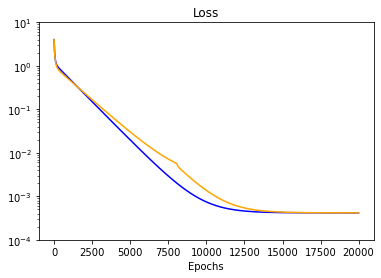

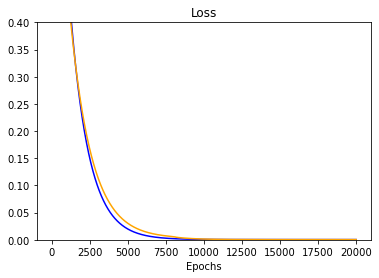

In [15]:
plt.plot(log_period*np.arange(len(linear_loss_tr)), linear_loss_tr, 'blue')
plt.plot(log_period*np.arange(len(linear_loss_tr)), relu_loss_tr, 'orange')
# plt.plot(log_period*np.arange(len(linear_loss_tr)), np.zeros(len(linear_loss_tr)), 'k') # x axis
plt.xlabel('Epochs')
plt.title('Loss')
plt.ylim(0.0001,10)
plt.yscale('log')

savefig(f'{output_path}/Loss_{Epochs}.png')

plt.plot(log_period*np.arange(len(linear_loss_tr)), linear_loss_tr, 'blue')
plt.plot(log_period*np.arange(len(linear_loss_tr)), relu_loss_tr, 'orange')
# plt.plot(log_period*np.arange(len(linear_loss_tr)), np.zeros(len(linear_loss_tr)), 'k') # x axis
plt.xlabel('Epochs')
plt.title('Loss')
plt.ylim(0,0.4)
# plt.yscale('log')

savefig(f'{output_path}/Loss_{Epochs}_2.png')